<h1 align="center">Introduction to Theano</h1>

<h2 align="center">Jorge A. Vanegas</h2>

<div align="center"><img src="images/mindlab-logo-simple.png" style="width: 160px; display: inline; padding:25px;"> <img src="images/unal-logo.png" style="width: 150px; display: inline; padding: 0 0 20px 0;"></div>

# Outline

* What’s Theano?
* Using Theano
* Basic Usage
* ** Advanced Usage ** 
* ** Case study 1: Logistic Regression ** 
* ** Case study 2: Multi-layer Perceptron ** 

# Using the CPU vs GPU
Theano can transparently compile onto different hardware. What device it uses by default depends on your **.theanorc** file and any environment variables defined, as described in detail here: http://deeplearning.net/software/theano/library/config.html 

For convenience, Theano provides the floatX configuration variable which designates what float accuracy to use. For example, you can run a Python script with certain environment variables set to use the CPU:


    THEANO_FLAGS=device=cpu,floatX=float64 python your_script.py

or GPU:

    THEANO_FLAGS=device=gpu,floatX=float32 python your_script.py
    
**.theanorc**:

    [global]
    floatX = float32
    device = gpu0
    mode=FAST_RUN
    exception_verbosity=high

You can get the values being used to configure Theano like so:

In [1]:
import theano
print(theano.config.device)
print(theano.config.floatX)

cpu
float64


You can also get/set them at runtime:

In [2]:
old_floatX = theano.config.floatX
theano.config.floatX = 'float32'

Be careful that you're actually using floatX!

In [3]:
import numpy as np
# For example, the following will cause var to be a float64 regardless of floatX due to numpy defaults:
var = theano.shared(np.array([1.3, 2.4]))
print(var.type()) #!!! 

<TensorType(float64, vector)>


In [4]:
# So, whenever you use a numpy array, make sure to set its dtype to theano.config.floatX
var = theano.shared(np.array([1.3, 2.4], dtype=theano.config.floatX))
print(var.type())
# Revert to old value
theano.config.floatX = old_floatX

<TensorType(float32, vector)>


# Testing Theano with GPU

    check_theano.py:


In [5]:
from theano import function, config, shared, sandbox
import theano.tensor as T
import numpy
import time

vlen = 10 * 30 * 768  # 10 x #cores x # threads per core
iters = 1000

rng = numpy.random.RandomState(22)
x = shared(numpy.asarray(rng.rand(vlen), config.floatX))
f = function([], T.exp(x))
print(f.maker.fgraph.toposort())
t0 = time.time()
for i in xrange(iters):
    r = f()
t1 = time.time()
print("Looping %d times took %f seconds" % (iters, t1 - t0))
print("Result is %s" % (r,))
if numpy.any([isinstance(x.op, T.Elemwise) for x in f.maker.fgraph.toposort()]):
    print('Used the cpu')
else:
    print('Used the gpu')

[Elemwise{exp,no_inplace}(<TensorType(float64, vector)>)]
Looping 1000 times took 4.087998 seconds
Result is [ 1.23178032  1.61879341  1.52278065 ...,  2.20771815  2.29967753
  1.62323285]
Used the cpu


device=cpu
<pre><code>
$ THEANO_FLAGS=mode=FAST_RUN,device=cpu,floatX=float32 python check_theano.py      
[Elemwise{exp,no_inplace}(<TensorType(float32, vector)>)]                                                              
Looping 1000 times took 2.204147 seconds                                                                                
Result is [ 1.23178029  1.61879337  1.52278066 ...,  2.20771813  2.29967761                                           
 1.62323284]                                                                                                            
Used the cpu
</code></pre>

device=gpu
<pre><code>
$ THEANO_FLAGS=mode=FAST_RUN,device=gpu,floatX=float32 python check_theano.py      
Using gpu device 0: Graphics Device (CNMeM is disabled)                                                               [GpuElemwise{exp,no_inplace}(<CudaNdarrayType(float32, vector)>), HostFromGpu(GpuElemwise{exp,no_inplace}.0)]
Looping 1000 times took 0.311079 seconds                                                                               
Result is [ 1.23178029  1.61879349  1.52278066 ...,  2.20771813  2.29967761                                           
  1.62323296]                                                                                                         
Used the gpu
</code></pre>

# Case study 1: Logistic Regression


<table style="border:none;">
<tr style="border:none;">
<td style="border:none;"> 
    
<ul style="width: 400px;">
<li>Binary classification</li>
<br>
<li>Discriminative function</li>
<br>
$$ 𝑝(𝑦 = 1|𝑥) =\frac{1}{1+exp(−𝑤∙𝑥−𝑏)}$$
<br>
<li>Objective function</li>
<br>
Cross-entropy
<br>
$$ 𝐽 = −𝑦∙log(𝑝) − (1 − 𝑦)∙log(1 − 𝑝) $$
<br>
</ul>

</td>
<td style="border:none; width: 250px;">
    
<img src="images/classification-problem.png" style="width: 150px;"> 
<img src="images/sigmoid.png" style="width: 150px;"> 
<img src="images/sigmoid-function.png" style="width: 150px;">

</td> 
</tr>
</table>

# Case study 1: Logistic Regression

In [6]:
import numpy
import theano
import theano.tensor as T
from collections import OrderedDict 

rng = numpy.random

N = 400 # number of samples
feats = 784 # dimensionality of features
D = (rng.randn(N, feats), rng.randint(size=N, low=0, high=2))
training_steps = 1000

In [7]:
# declare Theano symbolic variables
x = T.matrix('x')
y = T.vector('y')
w = theano.shared(rng.randn(784), name='w')
b = theano.shared(0., name='b')

In [8]:
print "Initial model:"
print w.get_value(), b.get_value()

Initial model:
[ -1.58300662e-01  -7.86673912e-01   5.45826327e-01  -3.37237108e-02
   2.19104334e+00   1.95970494e+00   1.87966449e+00  -7.86341466e-01
  -7.96395907e-01  -2.19368160e-01  -1.16401413e+00  -9.13044626e-01
   5.40199742e-01  -8.01253474e-02  -1.47752234e+00   6.29985900e-01
   2.41972598e-01  -1.31578868e+00   1.75285145e+00   4.25742130e-01
  -3.03169942e-01   1.00367204e+00  -1.46657382e+00   3.10413131e-01
  -9.79324566e-01   1.09644697e+00  -5.06601623e-01   1.89847590e+00
   7.20443847e-02  -1.01315217e-01  -3.57833383e-01  -3.21251945e-01
   5.93337270e-01  -1.17358387e-01  -4.72176233e-01   1.30402152e+00
  -9.59207081e-01  -1.06604713e+00  -1.04597555e+00  -4.96854601e-01
   1.69961939e+00  -4.61857519e-01   7.73272581e-01   2.86219966e-01
  -1.82938652e+00   8.11405173e-01   5.37152187e-02   2.07547891e-01
   1.62284578e+00  -1.84057038e+00   3.24260806e-01   3.30403643e-01
   9.43287907e-01   1.19837087e+00  -9.95815695e-01   6.67630838e-01
  -1.09072037e+00  

In [9]:
# Construct Theano expression graph

$$ 𝑝(𝑦 = 1|𝑥) =\frac{1}{1+exp(−𝑤∙𝑥−𝑏)} $$

In [10]:
p_1 = 1 / (1 + T.exp(-T.dot(x, w) - b)) # probability that target = 1
prediction = p_1 > 0.5 # the prediction threshold

$$ cost = avg(J(p_1)) + \lambda∙\left \| W \right \|_2^2$$

In [11]:
xent = -y*T.log(p_1) - (1 - y)*T.log(1 - p_1) # cross-entropy loss function
cost = xent.mean() + 0.01 * (w**2).sum() # the cost to minimize

gw, gb = T.grad(cost, [w, b])

Gradient descent:  $ \theta \leftarrow \theta - \gamma \cdot \frac{\partial }{\partial \theta}L $

In [12]:
# Compile
train = theano.function(
    inputs = [x, y],
    outputs = [prediction, xent, cost],
    updates = 
        OrderedDict([(w, w - 0.1*gw), 
                     (b, b - 0.1*gb)]),
    allow_input_downcast=True)
predict = theano.function(
    inputs = [x], 
    outputs = prediction,
    allow_input_downcast=True)

In [13]:
# Train
predictions = []
errors = []
costs = []
fmeasures = []

In [14]:
# Train
for i in range(training_steps):
    pred, err, cost = train(D[0], D[1])
    
    predictions.append(pred)
    errors.append(err)
    costs.append(cost)

In [15]:
# show errors
import matplotlib.pyplot as plt
from sklearn.metrics import f1_score
%matplotlib inline

iterations = range(training_steps)

for i in iterations:
    fmeasures.append(f1_score(D[1], predictions[i]))

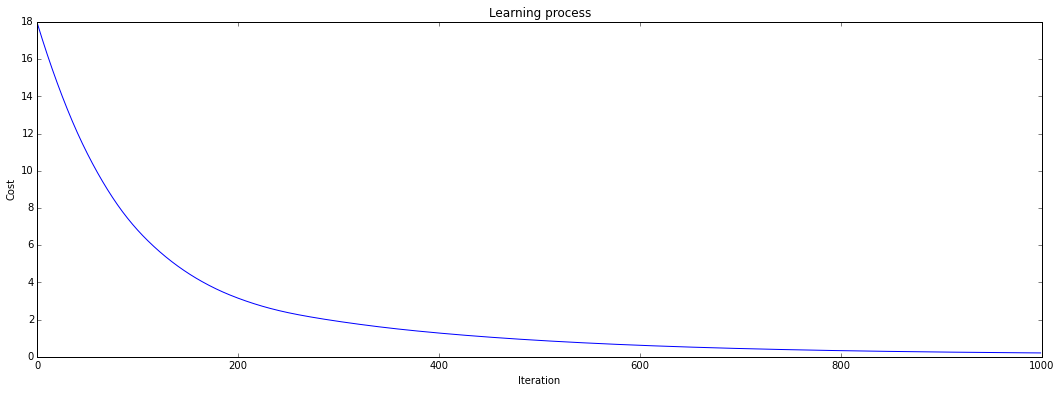

In [16]:
plt.figure(figsize=(18, 6))
plt.plot(iterations, costs, 'b')
plt.title('Learning process')
plt.xlabel("Iteration")
plt.ylabel("Cost")
plt.show()

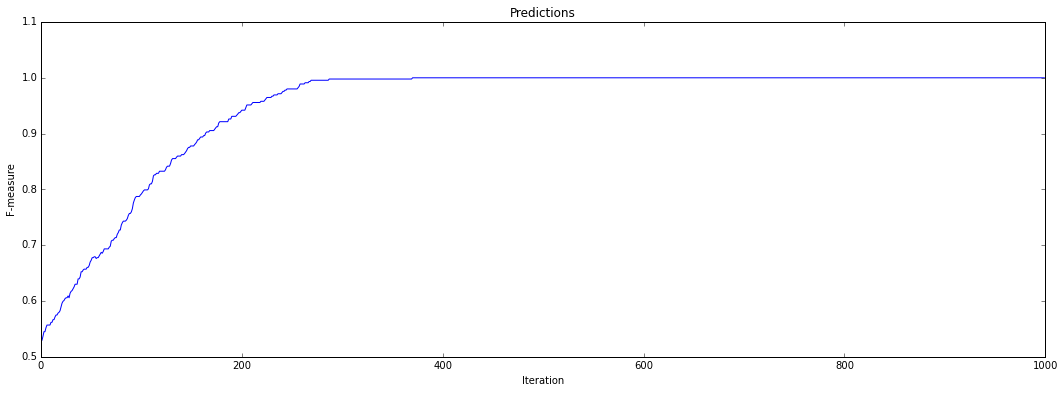

In [17]:
plt.figure(figsize=(18, 6))
plt.plot(iterations, fmeasures, 'b')
plt.title('Predictions')
plt.xlabel("Iteration")
plt.ylabel("F-measure")
plt.show()

In [18]:
# print "Final model:"
# print w.get_value(), b.get_value()
# print "target values for D: ", D[1]
# print "predictions on D: ", predict(D[0])

# Case study 2: Multi-Layer Perceptron


<table style="border:none;">
<tr style="border:none;">
<td style="border:none;"> 
    
<ul style="width: 450px;">
<li>Hidden layer(s)</li>
<br>
<li>Discriminative function</li>
<br>
$$ 𝑝(𝑦 = 1|𝑥) = f(w_2∙(g(w_1∙x + b_1) + b_2))$$
<br>
$f$ and $g$ can be $sigmoid/tanh$ functions
<br>
<br>
<li>Objective function</li>
<br>
Cross-entropy
<br>
$$ 𝐽 = −𝑦∙log(𝑝) − (1 − 𝑦)∙log(1 − 𝑝) $$
<br>
</ul>

</td>
<td style="border:none; width: 250px;">
    
<img src="images/multilayer.png" style="width: 200px;"> 
<img src="images/sigmoid-function.png" style="width: 200px;">

</td> 
</tr>
</table>

# Case study 2: Multi-Layer Perceptron

In [19]:
import numpy
import theano
import theano.tensor as T
rng = numpy.random

N = 400 # number of samples
feats = 784 # dimensionality of features
D = (rng.randn(N, feats), rng.randint(size=N, low=0, high=2))
training_steps = 1000

In [20]:
# declare Theano symbolic variables
x = T.matrix('x')
y = T.vector('y')
w_1 = theano.shared(rng.randn(784,300), name='w1')
b_1 = theano.shared(numpy.zeros((300,)), name='b1')
w_2 = theano.shared(rng.randn(300), name='w2')
b_2 = theano.shared(0., name='b2')

In [21]:
# print "Initial model:"
# print w_1.get_value(), b_1.get_value()
# print w_2.get_value(), b_2.get_value()

In [22]:
# Construct Theano expression graph
p_1 = T.nnet.sigmoid(-T.dot(T.nnet.sigmoid(-T.dot(x, w_1) - b_1), w_2) - b_2)
# probability that target = 1
prediction = p_1 > 0.5 # the prediction threshold
xent = -y*T.log(p_1) - (1 - y)*T.log(1 - p_1) # cross-entropy loss func
cost = xent.mean() + 0.01 * (w**2).sum() # the cost to minimize
gw_1, gb_1, gw_2, gb_2 = T.grad(cost, [w_1, b_1, w_2, b_2])

In [23]:
# Compile
train = theano.function(
    inputs = [x, y],
    outputs = [prediction, xent, cost],
    updates = 
        OrderedDict([(w_1, w_1 - 0.1*gw_1), 
                     (b_1, b_1 - 0.1*gb_1),
                     (w_2, w_2 - 0.1*gw_2),
                     (b_2, b_2 - 0.1*gb_2)
                    ]),
    allow_input_downcast=True)
predict = theano.function(
    inputs = [x], 
    outputs = prediction, 
    allow_input_downcast=True)

In [24]:
# Train
predictions = []
errors = []
costs = []
fmeasures = []

In [25]:
# Train
for i in range(training_steps):
    pred, err, cost = train(D[0], D[1])
    
    predictions.append(pred)
    errors.append(err)
    costs.append(cost)

In [26]:
# show errors
import matplotlib.pyplot as plt
from sklearn.metrics import f1_score
%matplotlib inline

iterations = range(training_steps)

for i in iterations:
    fmeasures.append(f1_score(D[1], predictions[i]))

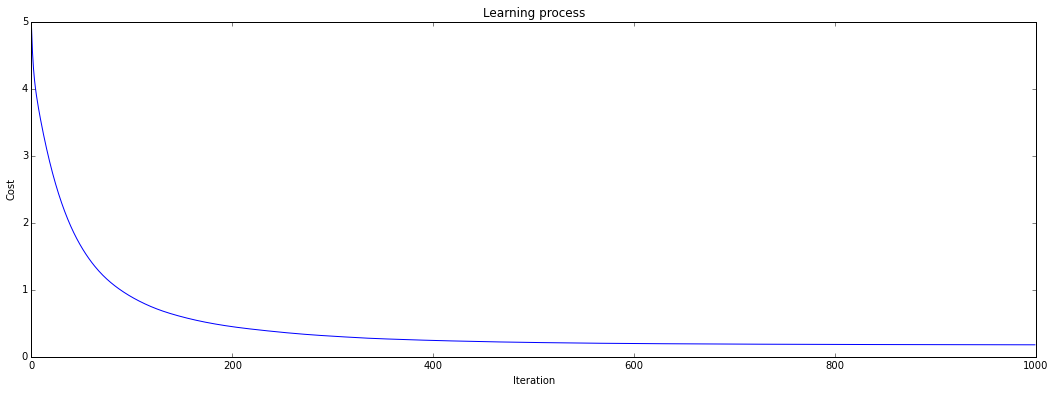

In [27]:
plt.figure(figsize=(18, 6))
plt.plot(iterations, costs, 'b')
plt.title('Learning process')
plt.xlabel("Iteration")
plt.ylabel("Cost")
plt.show()

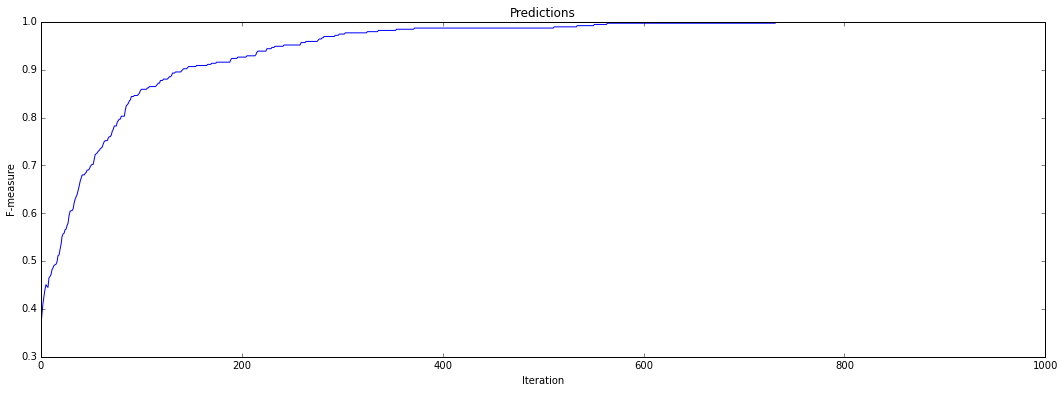

In [28]:
plt.figure(figsize=(18, 6))
plt.plot(iterations, fmeasures, 'b')
plt.title('Predictions')
plt.xlabel("Iteration")
plt.ylabel("F-measure")
plt.show()

In [29]:
# print "Final model:"
# print w_1.get_value(), b_1.get_value()
# print w_2.get_value(), b_2.get_value()
# print "target values for D: ", D[1]
# print "predictions on D: ", predict(D[0])